In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time as time
from IPython.display import clear_output
import torch 
from torch import optim

In [32]:
a=1e-3
b=1e10
Max=np.pi*2
LabelSize=20

#y=1+(x-0)**(2)/b
torch.set_printoptions(precision=10)

def function(x):
    x=x%(np.pi*2)
    x2=(x-0)**2
    y=np.exp(-(x2.sum())/a)+x2.sum()/b

    return 1-y

def function_torch(x):
    x2=(x-0)**2
    y=torch.exp(-(x2.sum()/a))+x2.sum()/b
    return 1-y


def derivative(x):
    y=function(x)
    d=2*(x-0)*(y-1)/(a)+(2*x)/(b)
    return d


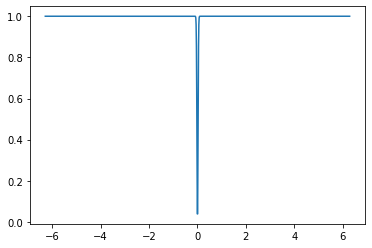

In [33]:
x=np.linspace(-np.pi*2,2*np.pi,1000)
y=1-np.exp(-((x-0)**2)/a)+(x-0)**(2)/b
plt.plot(x,y)

In [34]:
def myAlg(weights,nSteps=10000,learning_rate=1e-1,low=1e-2,high=3e-1,alpha=0.1,
                  threshold=1e-5):

    List={"cost":[],"rate":[],"grad":[],"I":[0],"weights":[],"soln_d":[]}
    
    for i in range(nSteps):

        t1=time.time()
        
        cost=function(weights)
        grad=derivative(weights)
        if i>1:
            I=getI(cost,List['cost'][-1],grad,List['grad'][-1])
            List['I'].append(I)
            
            
            if I<low:
                    learning_rate=learning_rate*(1+alpha)

            if I>high:
                    learning_rate=learning_rate*(1-alpha)
#             if cost>0.1:
#                 if I<low:
#                     learning_rate=learning_rate*(1+alpha)

#                 if I>high:
#                     learning_rate=learning_rate*(1-alpha)
#             else:
              
#                 if I<low:
#                     learning_rate=learning_rate*(1+0.1*alpha)

#                 if I>high:
#                     learning_rate=learning_rate*(1-0.1*alpha)
            
            if getMag(grad)/getMag(List['grad'][-1])>10:
                stopper=getMag(List['grad'][-1])/getMag(grad)
                learning_rate=learning_rate*stopper*1e-2


        weights = weights+learning_rate*grad
        
#         weights[weights>Max]=Max
#         weights[-weights>Max]=-Max
        List['weights'].append(weights)        
        List['cost'].append(cost)
        List['grad'].append(grad)
        List['rate'].append(learning_rate)
        List['soln_d'].append(np.sqrt((weights**2).sum()))
        
        if cost<1e-10:
            break
        if i==nSteps-1:

            #clear_output(wait=True)
            plt.figure(1)
            #plt.yscale('log')
            plt.plot(range(len(List['cost'])),List['cost'])
            plt.figure(2)
            plt.yscale('log')
            plt.plot(range(len(List['rate'])),List['rate'])
            plt.figure(3)
            plt.yscale('log')
            plt.plot(range(len(List['I'])),List['I'])

    return List

def getMag(x):
    x2=x**2
    return np.sqrt(x2.sum())

def getI(cx,cy,x,y):
    cos=(x*y).sum()/(getMag(x)*getMag(y))
    return (1-cos)

In [35]:
initial_rate=[1e-10,1e-5,1e0,1e5,1e10]

myAlg_results={}

In [36]:
for rate in initial_rate:
    

    weights=np.random.rand(10)*(10*np.pi)
    cost_list_myAlg=myAlg(weights,nSteps=1000,learning_rate=rate,low=1e-4,high=5e-1,alpha=0.1)
    myAlg_results[str(rate)]=cost_list_myAlg

<Figure size 432x288 with 0 Axes>

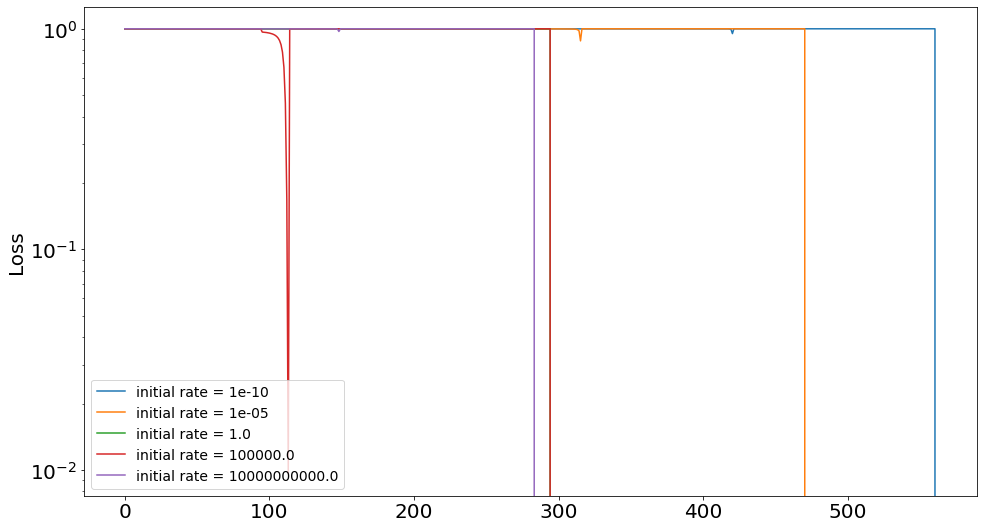

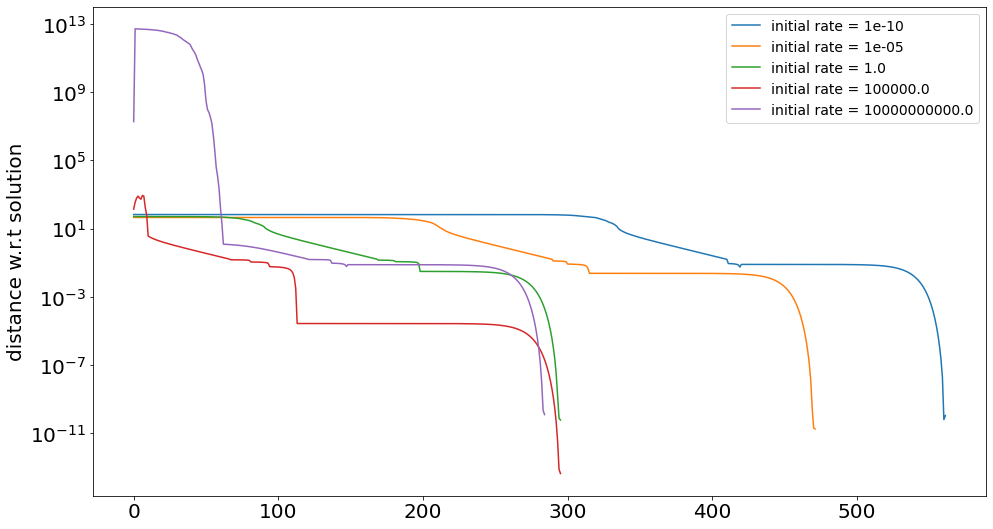

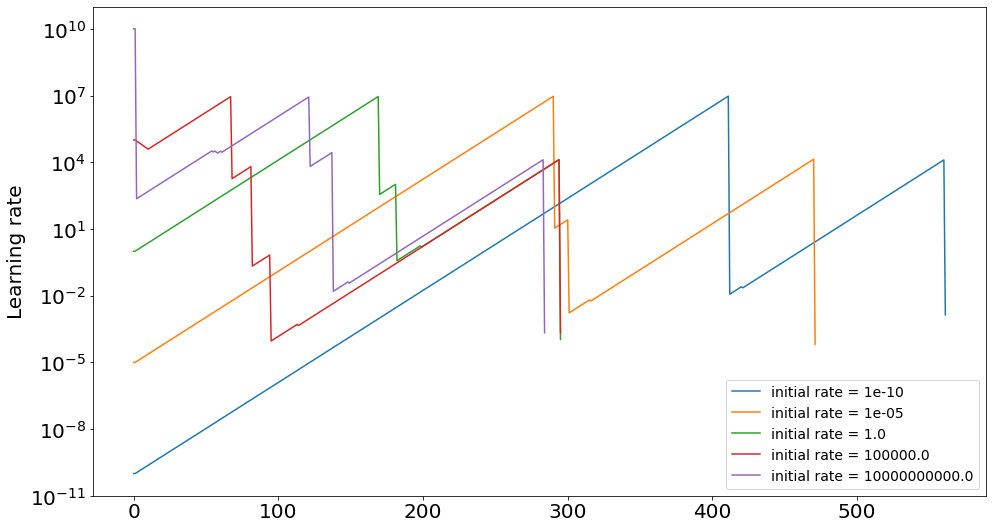

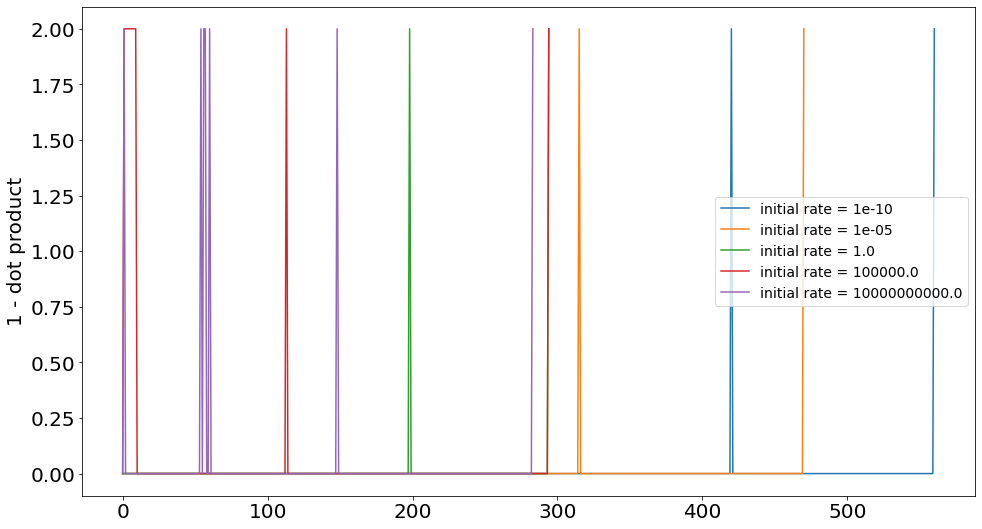

In [37]:
plt.figure(1)
plt.figure(figsize=(16,9))
for rate in initial_rate:
    tmp_results=myAlg_results[str(rate)]
    plt.plot(range(len(tmp_results['cost'])),tmp_results['cost'],label='initial rate = {}'.format(rate))
plt.yscale('log')
plt.ylabel('Iterations',fontsize=LabelSize)
plt.ylabel('Loss',fontsize=LabelSize)
plt.tick_params(axis='both', which='major', labelsize=LabelSize)
plt.legend(fontsize=LabelSize*0.7)


plt.figure(2)
plt.figure(figsize=(16,9))
for rate in initial_rate:
    tmp_results=myAlg_results[str(rate)]
    plt.plot(range(len(tmp_results['soln_d'])),tmp_results['soln_d'],label='initial rate = {}'.format(rate))
plt.yscale('log')
plt.ylabel('Iterations',fontsize=LabelSize)
plt.ylabel('distance w.r.t solution',fontsize=LabelSize)
plt.tick_params(axis='both', which='major', labelsize=LabelSize)
plt.legend(fontsize=LabelSize*0.7)

plt.figure(3)
plt.figure(figsize=(16,9))
for rate in initial_rate:
    tmp_results=myAlg_results[str(rate)]
    plt.plot(range(len(tmp_results['rate'])),tmp_results['rate'],label='initial rate = {}'.format(rate))
plt.yscale('log')
plt.ylabel('Iterations',fontsize=LabelSize)
plt.ylabel('Learning rate',fontsize=LabelSize)
plt.tick_params(axis='both', which='major', labelsize=LabelSize)
plt.legend(fontsize=LabelSize*0.7)

plt.figure(4)
plt.figure(figsize=(16,9))
for rate in initial_rate:
    tmp_results=myAlg_results[str(rate)]
    plt.plot(range(len(tmp_results['I'])),np.array(tmp_results['I']),label='initial rate = {}'.format(rate))
#plt.yscale('log')
#plt.xlim(130,200)
plt.ylabel('Iterations',fontsize=LabelSize)
plt.ylabel('1 - dot product',fontsize=LabelSize)
plt.tick_params(axis='both', which='major', labelsize=LabelSize)
plt.legend(fontsize=LabelSize*0.7)


SGD

In [26]:
import torch.nn as nn
class DefaultModel(nn.Module):
    def __init__(self, guess):
        super(DefaultModel, self).__init__()
        self.T = torch.tensor(guess).unsqueeze(0)
        self.T.requires_grad = True

    def forward(self):
        xx=self.T%(np.pi*2)
        loss = function_torch(xx)

        return loss

In [40]:
max_iter=1000
loss_ADAM={}

In [41]:
for rate in initial_rate:
    tmpLoss_ADAM=[]
    guess=np.random.rand(10)*(10*np.pi)
    model=DefaultModel(guess)
    optimizer = torch.optim.Adam([model.T], lr=rate)
    for i in range(max_iter):
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        loss = model.forward()  # Calculate loss
        loss.backward()  # Backward pass

        tmpLoss_ADAM.append(loss.detach().numpy())
        optimizer.step()
    loss_ADAM[str(rate)]=tmpLoss_ADAM


(0.0, 1.2)

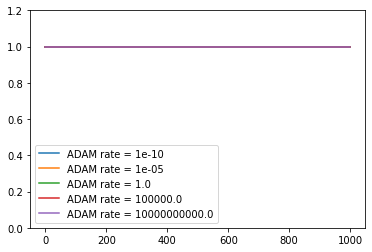

In [53]:
for rate in initial_rate:
    plt.plot(range(max_iter),loss_ADAM[str(rate)],label="ADAM rate = {}".format(rate))
    
plt.legend()
plt.ylim(0,1.2)
#plt.yscale('log')